### PROJECT

##### Generate a multimodal agent that will take both texts and images and give an output

#### Key Components


1. State management: Using TypedDict to define and manage the state of each user interaction.

2. Workflow Graph: Utilizing LangGraph.

3. Initializing the OCR and BLIP to interact with the image.

#### TERMS

##### OCR(Optical Character Recognition)
###### OCR is a technology that scans an image (like a photo, scanned document, or screenshot) and detects the characters, words, and sometimes even layout.

##### BLIP(Bootstrapping Language-Image Pretraining)
###### A multimodal model that connects vision (images) and language (text).

### Method Details.
1. Initializing the .env environment and importing necessary libraries.

2. Creating a structure.

3. Implementing separate functions.

4. Using StateGraph to define the workflow before an output.

5. Compliling the graph into an execytable application.

6. Genarating an interface to interact with.

In [1]:
!pip install langgraph langchain_groq python-dotenv transformers pillow pytesseract

In [1]:
#Import Libraries
import os
from typing import TypedDict
from dotenv import load_dotenv
from langgraph.graph import StateGraph, END
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables.graph import MermaidDrawMethod
from langchain_groq import ChatGroq
from IPython.display import display, Image as IPyImage
from PIL import Image
import pytesseract
from transformers import BlipProcessor, BlipForConditionalGeneration

In [2]:
#Load the API
load_dotenv()
groq_api_key = os.getenv("GROQ_API_KEY")

if groq_api_key:
    print("Groq API key loaded successfully!")
else:
    print("Error: Missing Groq API key in .env file")

Groq API key loaded successfully!


In [3]:
#Define state structure
class State(TypedDict):
    query: str
    image_path: str
    image_description: str
    ocr_text: str
    response: str

In [4]:
#Initialize the Groq LLM 
llm = ChatGroq(
    temperature=0,
    groq_api_key=groq_api_key,
    model_name="llama-3.1-8b-instant"
)

In [5]:
#testing the model
result = llm.invoke("what is a cat")
result.content

'A cat, also known as a domestic cat or housecat, is a small, typically furry, carnivorous mammal that is often kept as a pet. Cats are members of the family Felidae and are closely related to other big cats, such as lions, tigers, and leopards.\n\nPhysical Characteristics:\n\n* Cats have a slender body, typically between 8-12 inches (20-30 cm) in length, and weigh between 8-20 pounds (3.5-9 kg).\n* They have a short, smooth coat that can be various colors and patterns, including solid, tabby, tortoiseshell, and calico.\n* Cats have retractable claws, which they use for climbing, hunting, and self-defense.\n* They have large, round eyes that are sensitive to light and can see in low light conditions.\n* Cats have a short, flexible spine that allows them to twist and turn with ease.\n\nBehavior:\n\n* Cats are known for their independence and aloofness, but they can also be affectionate and playful.\n* They are natural predators and have a strong instinct to hunt and kill small animals, 

In [6]:
#initialize the BLIP model for image captioning
processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
blip_model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base")


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

In [7]:
def describe_image(state: State) -> State:
    """Generate a caption for the image using BLIP"""
    try:
        raw_image = Image.open(state["image_path"]).convert("RGB")
        inputs = processor(raw_image, return_tensors="pt")
        out = blip_model.generate(**inputs, max_length=50)
        caption = processor.decode(out[0], skip_special_tokens=True)
    except Exception as e:
        caption = f"Could not caption image: {str(e)}"
    return {"image_description": caption}

In [8]:
def extract_text(state: State) -> State:
    """Extract visible text from the image using OCR"""
    try:
        raw_image = Image.open(state["image_path"])
        ocr_result = pytesseract.image_to_string(raw_image)
    except Exception as e:
        ocr_result = f"OCR failed: {str(e)}"
    return {"ocr_text": ocr_result.strip()}

In [9]:
#Initialise Groq
def reason_with_groq(state: State) -> State:
    """Use Groq LLM to reason on query + image description + OCR text"""
    prompt = ChatPromptTemplate.from_template("""
    You are a multimodal AI assistant. First describe the image, then answer the user's query.
    
    - Image description: {image_description}
    - OCR text: {ocr_text}
    - User query: {query}
    
    Provide a thoughtful, detailed response.
    """)
    chain = prompt | llm
    response = chain.invoke({
        "image_description": state["image_description"],
        "ocr_text": state["ocr_text"],
        "query": state["query"]
    }).content
    return {"response": response}

In [10]:
#Crafting the workflow
workflow = StateGraph(State)

workflow.add_node("describe_image", describe_image)
workflow.add_node("extract_text", extract_text)
workflow.add_node("reason_with_groq", reason_with_groq)

workflow.set_entry_point("describe_image")
workflow.add_edge("describe_image", "extract_text")
workflow.add_edge("extract_text", "reason_with_groq")
workflow.add_edge("reason_with_groq", END)

app = workflow.compile()

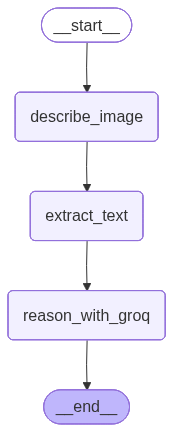

In [11]:
#Visualize the graph
display(IPyImage(app.get_graph().draw_mermaid_png(draw_method=MermaidDrawMethod.API)))

In [12]:
#Running the agent
def run_agent(query: str, image_path: str) -> dict:
    result = app.invoke({"query": query, "image_path": image_path})
    return {
        "image_description": result["image_description"],
        "ocr_text": result["ocr_text"],
        "response": result["response"]
    }

In [13]:
# # Test with images from my desktop
test_query = "What is happening in this picture?"
test_image = "5.jpg"  # replace with your own image path

output = run_agent(test_query, test_image)

print(" Image Description:", output["image_description"])
print(" OCR Extracted Text:", output["ocr_text"])
print(" Final Answer:", output["response"])

 Image Description: a man in a soccer uniform is running
 OCR Extracted Text: OCR failed: tesseract is not installed or it's not in your PATH. See README file for more information.
 Final Answer: Based on the image description, I can infer that the scene depicts a man in a soccer uniform, which suggests that he is likely a soccer player. The fact that he is running implies that he is in the midst of a game or a training session.

Given the context of a soccer player running, it is likely that he is either chasing after the ball, trying to catch up to an opponent, or sprinting down the field to gain an advantage. The image may be a snapshot of a dynamic moment in the game, capturing the player's speed and agility as he moves across the field.

Without more information or context, it is difficult to provide a more specific answer. However, based on the image description alone, it is clear that the man in the soccer uniform is engaged in a high-intensity physical activity, likely related 

In [14]:
# Test with images from my desktop
test_query = "What is happening in this picture?"
test_image = "Images/14.jpg"  # replace with your own image path

output = run_agent(test_query, test_image)

print(" Image Description:", output["image_description"])
print("OCR Extracted Text:", output["ocr_text"])
print(" Final Answer:", output["response"])

 Image Description: the girl in the dark is looking at the camera
OCR Extracted Text: OCR failed: tesseract is not installed or it's not in your PATH. See README file for more information.
 Final Answer: Based on the provided image description, I can infer that the picture shows a girl who is likely in a dimly lit or nighttime environment. She is directly looking at the camera, which suggests that she is either being photographed or is in a situation where she feels comfortable enough to be in front of the camera.

Given the lack of text from the OCR, I can only rely on the image description to provide context. However, I can make some educated guesses about what might be happening in the picture.

It's possible that the girl is in a situation where she feels a sense of vulnerability or intimacy, as she is directly looking at the camera. This could be due to a variety of reasons, such as being in a romantic setting, a moment of introspection, or even a sense of defiance.

Alternatively

In [15]:
import gradio as gr

def multimodal_agent_ui(query, image):
    if image is not None:  # Case 1: Image provided
        temp_path = "temp_image.jpg"
        image.save(temp_path)
        result = run_agent(query, temp_path)
        return f""" **Image Description:** {result['image_description']}  
**OCR Text:** {result['ocr_text']}  
**Answer:** {result['response']}"""
    
    else:  #Only text question
        # Just use Groq LLM directly
        prompt = f"User question: {query}\n\nAnswer thoughtfully as an AI assistant."
        response = llm.invoke(prompt).content
        return f"**Answer (Text-only):** {response}"

# Create UI
demo = gr.Interface(
    fn=multimodal_agent_ui,
    theme='Yntec/HaleyCH_Theme_Orange_Green',
    inputs=[
        gr.Textbox(label="Your Question"),
        gr.Image(type="pil", label="Upload an Image (Optional)")
    ],
    outputs=gr.Markdown(label="Agent Response"),
    title=" Multimodal AI Agent",
    description="Ask any question. Optionally upload an image for multimodal reasoning."
)

# Launch UI
demo.launch()

* Running on local URL:  http://127.0.0.1:7870
* To create a public link, set `share=True` in `launch()`.
